In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

# SIIM-ACR Pneumothorax Segmentation.

In [5]:
DEVICE = torch.device('cuda')
BATCH_SIZE = 1
DEBUG = False

## Data Loader.

In [22]:
from pydicom import dcmread
from lib.mask_functions import rle2mask
from torch.utils.data import Dataset, DataLoader

class SIIMDataset(Dataset):
    
    def __init__(self, name = 'train'):
        
        self.name, self.df = name, pd.read_csv('./dataset/{}.csv'.format(name))
    
    def __getitem__(self, idx):
        
        dcm = dcmread('./dataset/dicom-images-{}/{}.dcm'.format(self.name, self.df['ImageId'][idx]))
        
        height, width = dcm.Rows, dcm.Columns
        
        image = np.array(dcm.pixel_array) / 255
        
        mask = None
        
        if self.name == 'train':
            rle = self.df['EncodedPixels'][idx]
            
            if rle != '-1':
                mask = np.array(rle2mask(rle, width, height).T / 255)
            else:
                mask = np.zeros(width * height).reshape(width, height)
            
        return image, (mask if self.name == 'train' else idx)
    
    def __len__(self):
        
        if DEBUG:
            return 100 if self.name == 'trian' else 50
        
        return len(self.df)

## Training Samples.

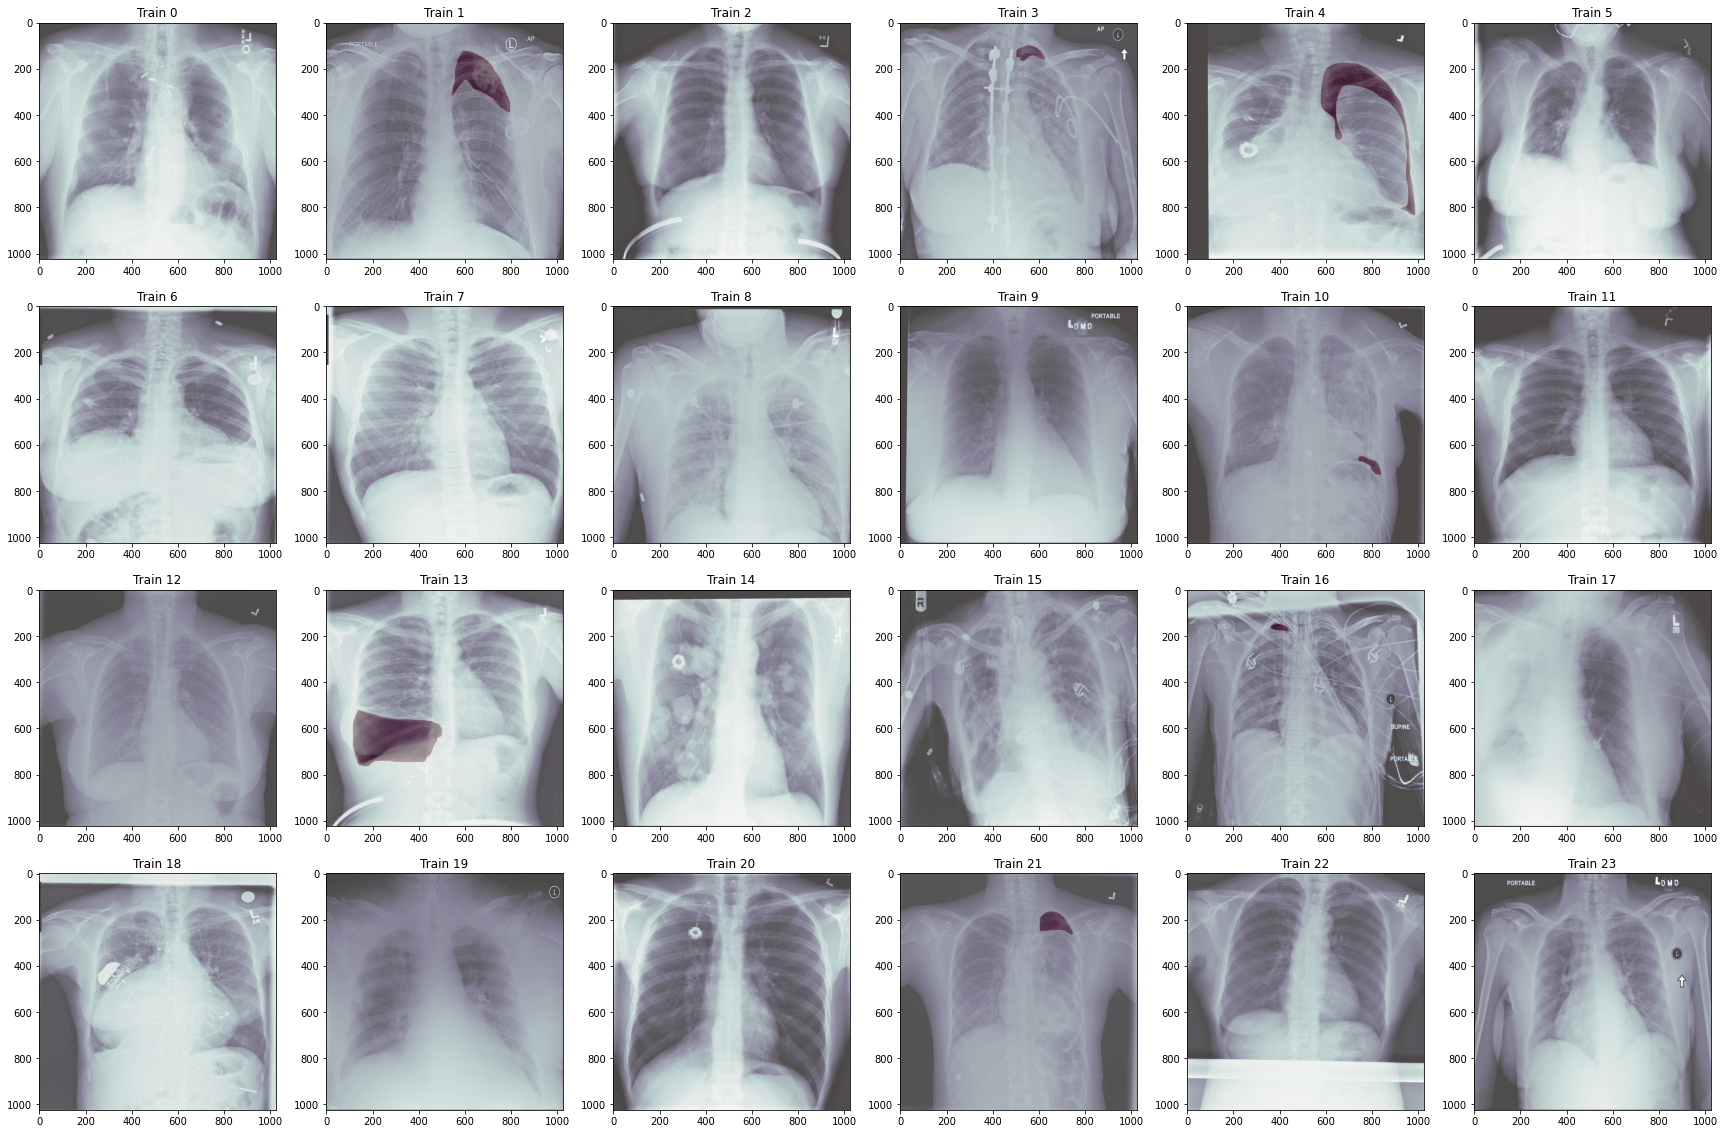

In [23]:
def training_samples(n = 4, m = 6):
    
    fig, axes = plt.subplots(n, m, figsize = (m * 5, n * 5))
    
    idx = 0
    
    for id, (image, mask) in enumerate(SIIMDataset('train')):
    
        axes[(idx // m), (idx % m)].set_title('Train {}'.format(id))

        axes[(idx // m), (idx % m)].imshow(image, cmap = plt.cm.bone)
        axes[(idx // m), (idx % m)].imshow(mask, alpha = 0.3, cmap = 'Reds')

        idx = idx + 1

        if idx == n * m:
            break

training_samples()

## Test Samples.

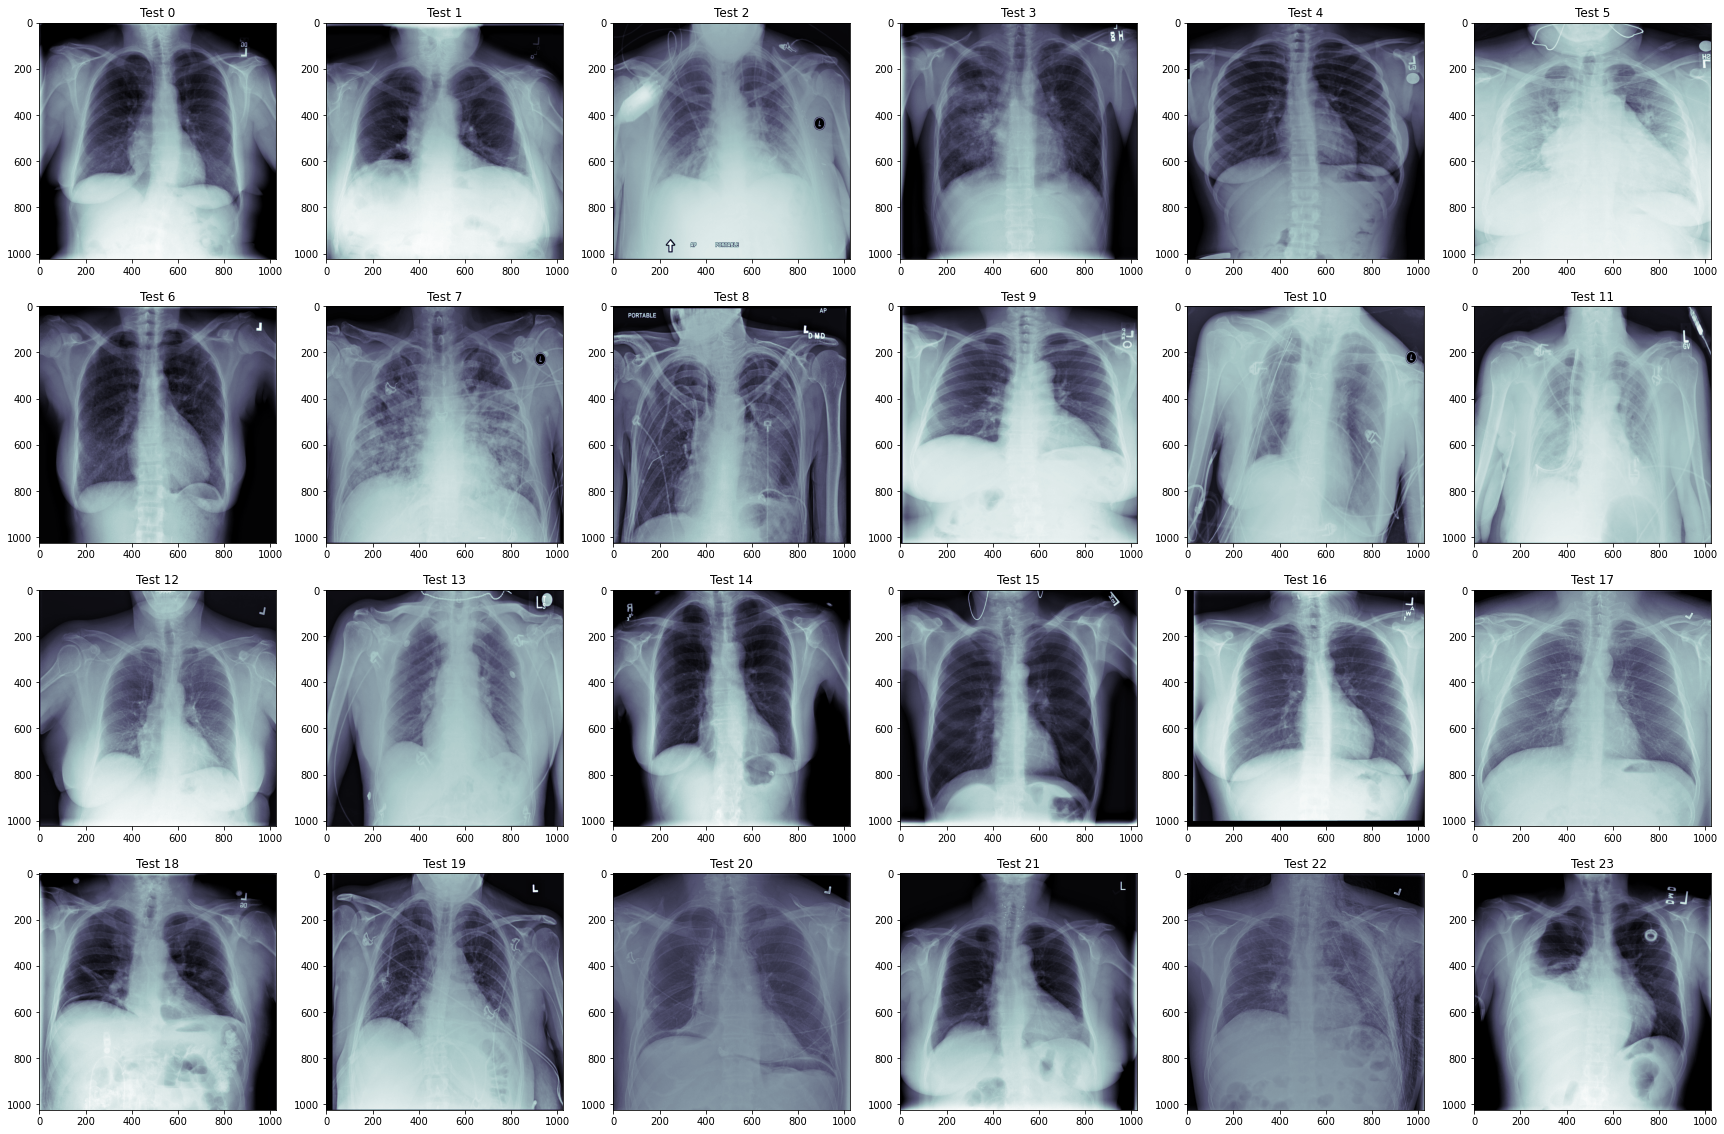

In [24]:
def test_samples(n = 4, m = 6):
    
    fig, axes = plt.subplots(n, m, figsize = (m * 5, n * 5))
    
    for idx, (image, _) in enumerate(SIIMDataset('test')):
    
        axes[(idx // m), (idx % m)].set_title('Test {}'.format(idx))
        axes[(idx // m), (idx % m)].imshow(image, cmap = plt.cm.bone)
        
        if idx == (n * m - 1):
            break

test_samples()

## Augmentation.

In [40]:
from lib.transforms import Noise, FlipLR, FlipUD, Rotate, Square, Resize
from torchvision.transforms import Compose, ToTensor, Normalize

class AugSIIMDataset(SIIMDataset):
    
    def __init__(self, name = 'train'):
        
        SIIMDataset.__init__(self, name)
    
    def __getitem__(self, idx):
        
        image, mask = SIIMDataset.__getitem__(self, idx)
        
        transform = Compose([
                Noise(),
                FlipLR(),
                FlipUD(),
                Rotate(),
                Square(),
                Resize(1024),
            ])
        
        h, w = image.shape
        
        image = transform(image.reshape(h, w, 1)).reshape(h, w)
        
        if self.name == 'train':
            mask = transform(mask.reshape(h, w, 1)).reshape(h, w)
        
        return np.array([ image ]), (mask if self.name == 'train' else idx)
    
    def __len__(self):
        
        return SIIMDataset.__len__(self)

## Augmentated Training Samples.

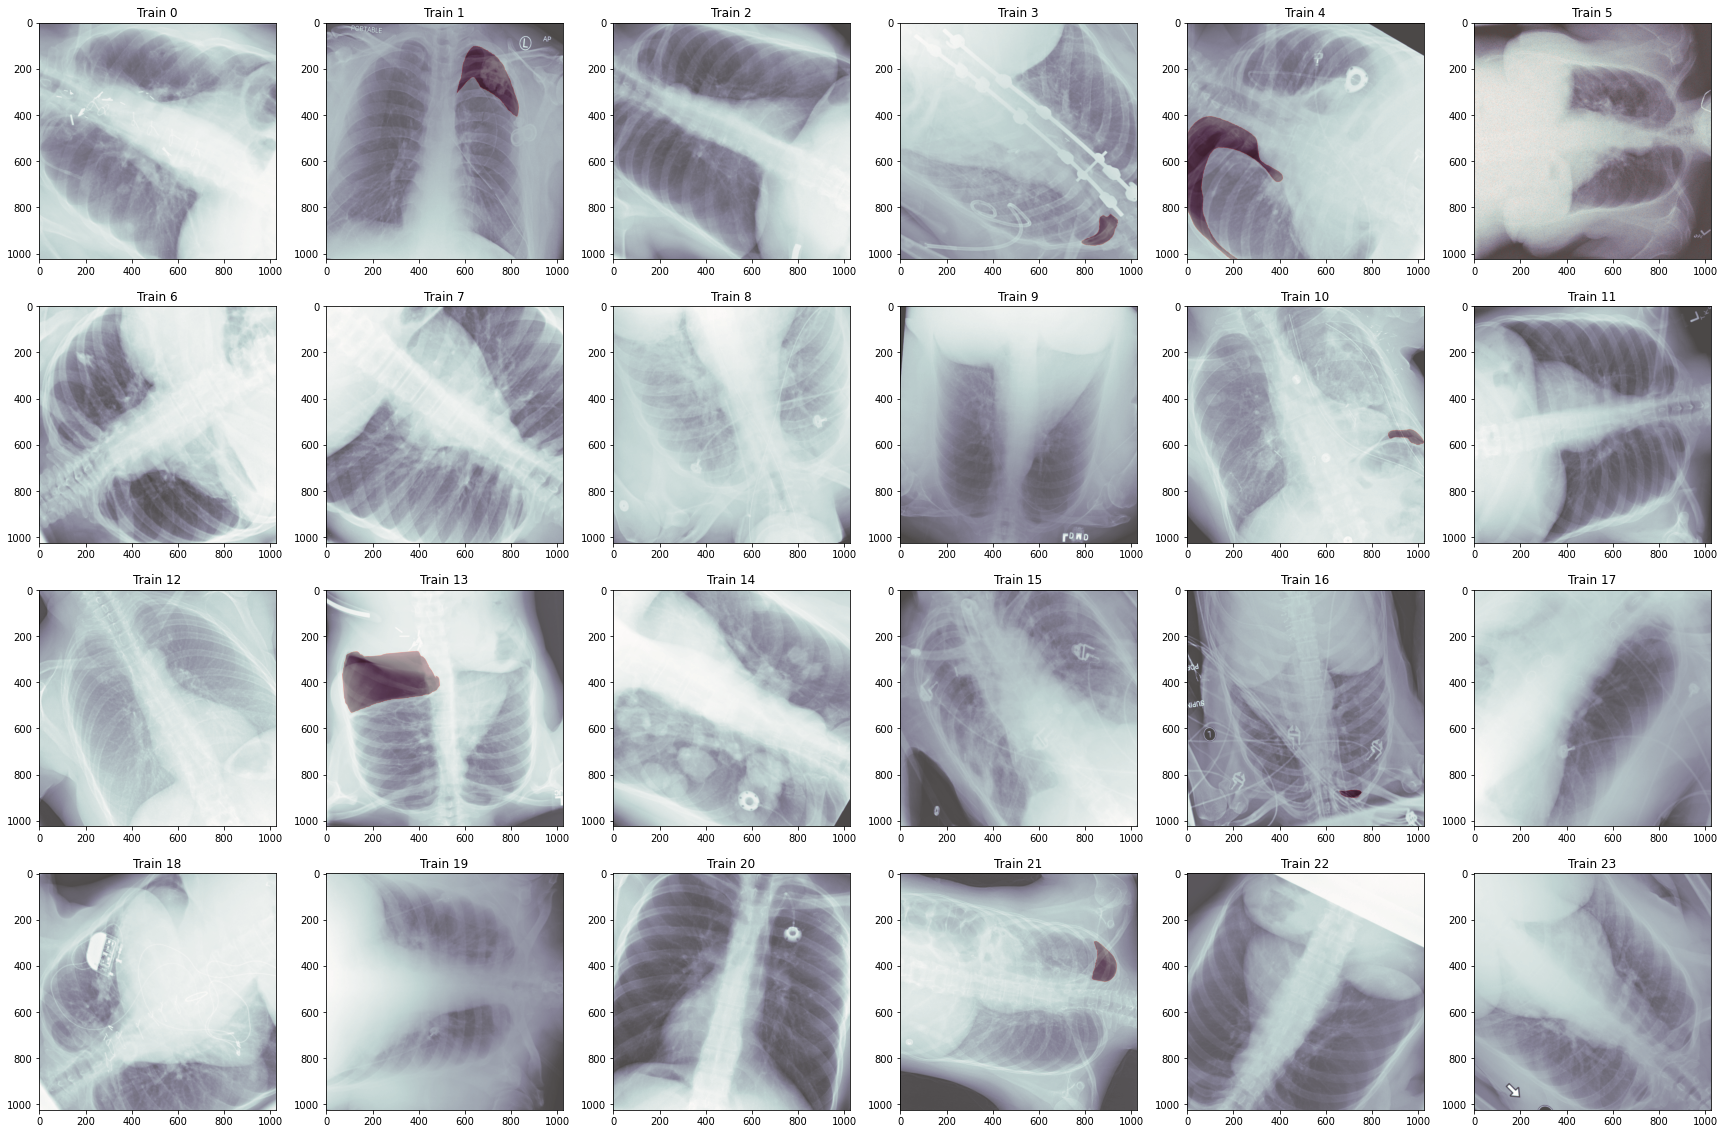

In [41]:
def aug_training_samples(n = 4, m = 6):
    
    fig, axes = plt.subplots(n, m, figsize = (m * 5, n * 5))
    
    idx = 0
    
    for id, (image, mask) in enumerate(AugSIIMDataset('train')):
    
        axes[(idx // m), (idx % m)].set_title('Train {}'.format(id))

        axes[(idx // m), (idx % m)].imshow(image[0], cmap = plt.cm.bone)
        axes[(idx // m), (idx % m)].imshow(mask, alpha = 0.3, cmap = 'Reds')

        idx = idx + 1

        if idx == n * m:
            break

aug_training_samples()

## Augmentated Test Samples.

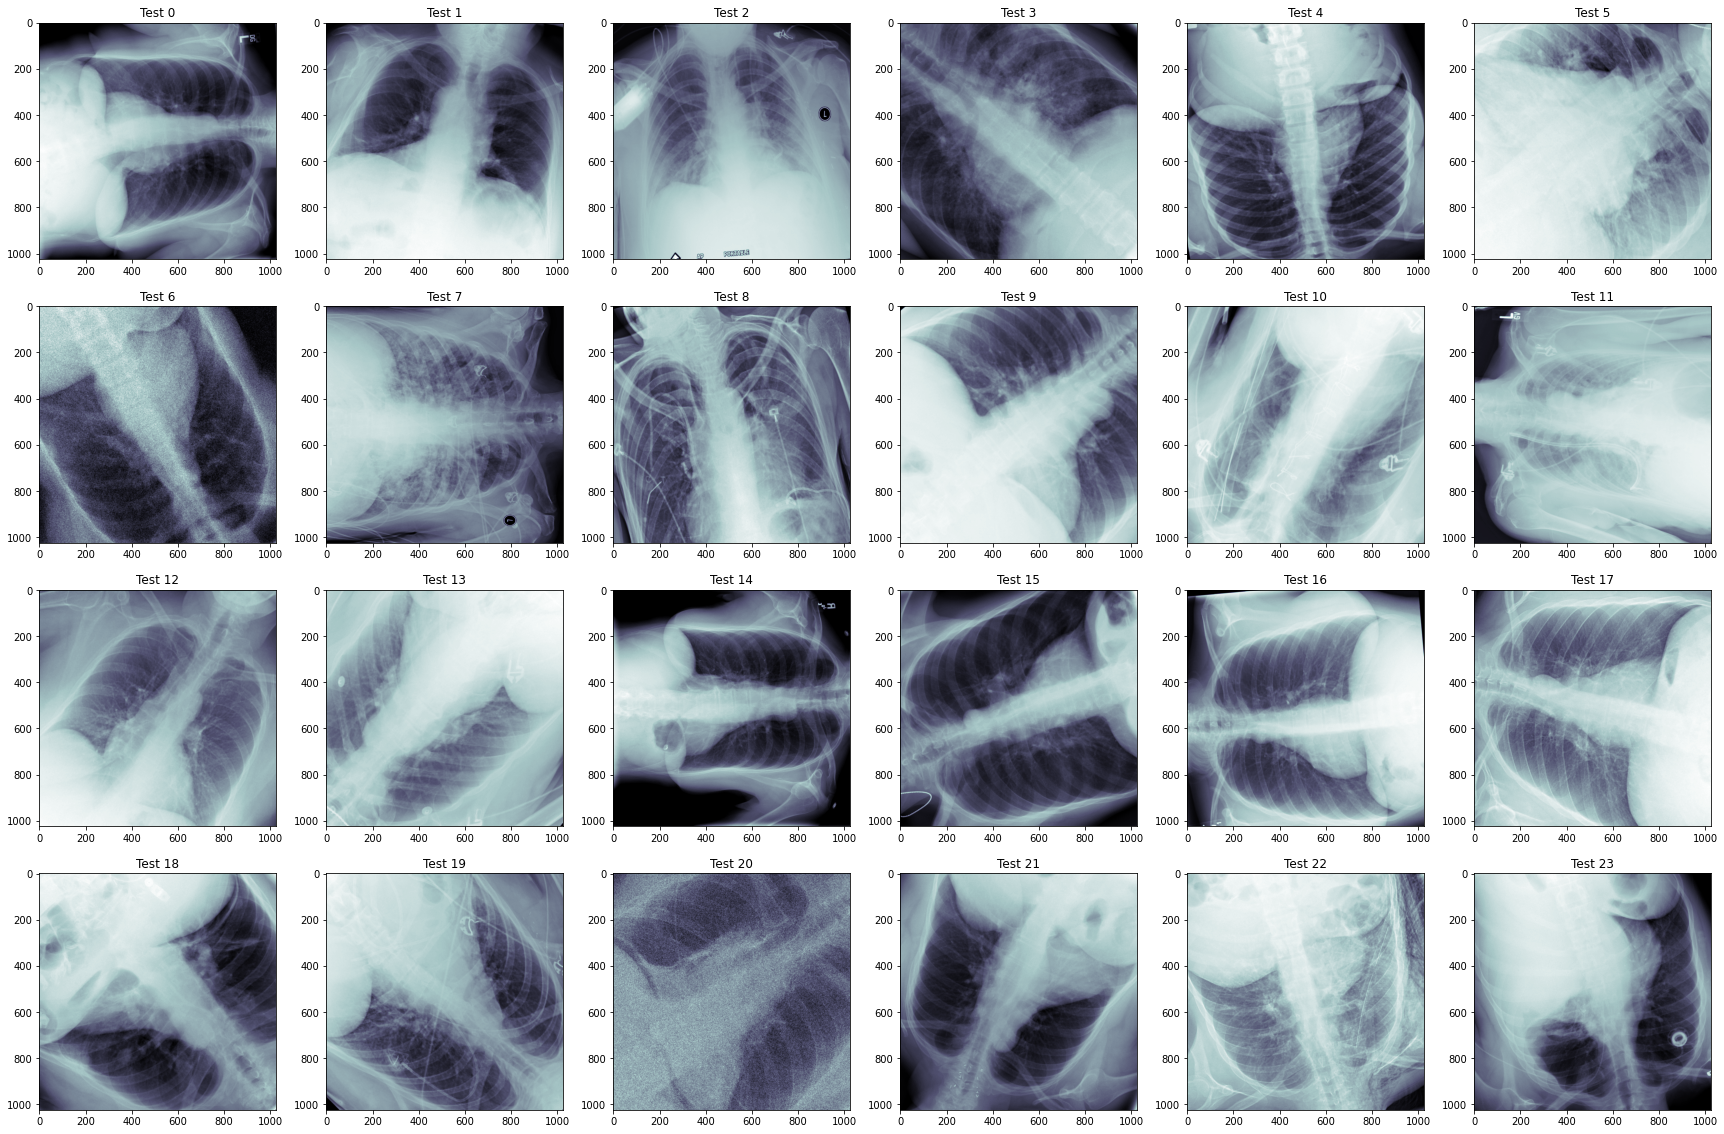

In [42]:
def aug_test_samples(n = 4, m = 6):
    
    fig, axes = plt.subplots(n, m, figsize = (m * 5, n * 5))
    
    for idx, (image, _) in enumerate(AugSIIMDataset('test')):
    
        axes[(idx // m), (idx % m)].set_title('Test {}'.format(idx))
        axes[(idx // m), (idx % m)].imshow(image[0], cmap = plt.cm.bone)
        
        if idx == (n * m - 1):
            break

aug_test_samples()

## Loss Function.

* $\text{dice_loss} = 1 - \frac{2 \lvert X \cup Y \rvert}{\lvert X \rvert + \lvert Y \rvert}$
* $\text{focal_loss} = \begin{cases} -\alpha (1 - \hat{y})^{\gamma} \log \hat{y} & y = 1 \\ -(1 - \alpha)\hat{y}^{\gamma} \log(1 - \hat{y}) & y = 0 \end{cases}$

In [6]:
from torch.nn.functional import binary_cross_entropy_with_logits

def dice_loss(outputs, masks, smooth = 1):

    outputs = outputs.view(-1)
    masks = masks.view(-1)
    
    s1 = (outputs * masks).sum()
    s2 = outputs.sum()
    s3 = masks.sum()

    return 1 - ((2 * s1 + smooth) / (s2 + s3 + smooth))

def focal_loss(outputs, masks, alpha = 1.0, gamma = 2.0):
    
    outputs = outputs.view(-1)
    masks = masks.view(-1)
    
    bce_loss = binary_cross_entropy_with_logits(outputs, masks, reduction = 'none')
    
    pt = torch.exp(-bce_loss)
    
    loss = alpha * (1 - pt) ** gamma * bce_loss
    
    return loss.mean()

def mixed_loss(outputs, masks, s = 0.5):
    
    return s * dice_loss(outputs, masks) + (1 - s) * focal_loss(outputs, masks)

## UNet Model with EfficientNet-B5 Encoder.

In [7]:
from segmentation_models_pytorch import Unet

model = Unet("efficientnet-b5", encoder_weights = "imagenet", in_channels = 1, activation = None).to(DEVICE)

## Trial of Single Image.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.81it/s]


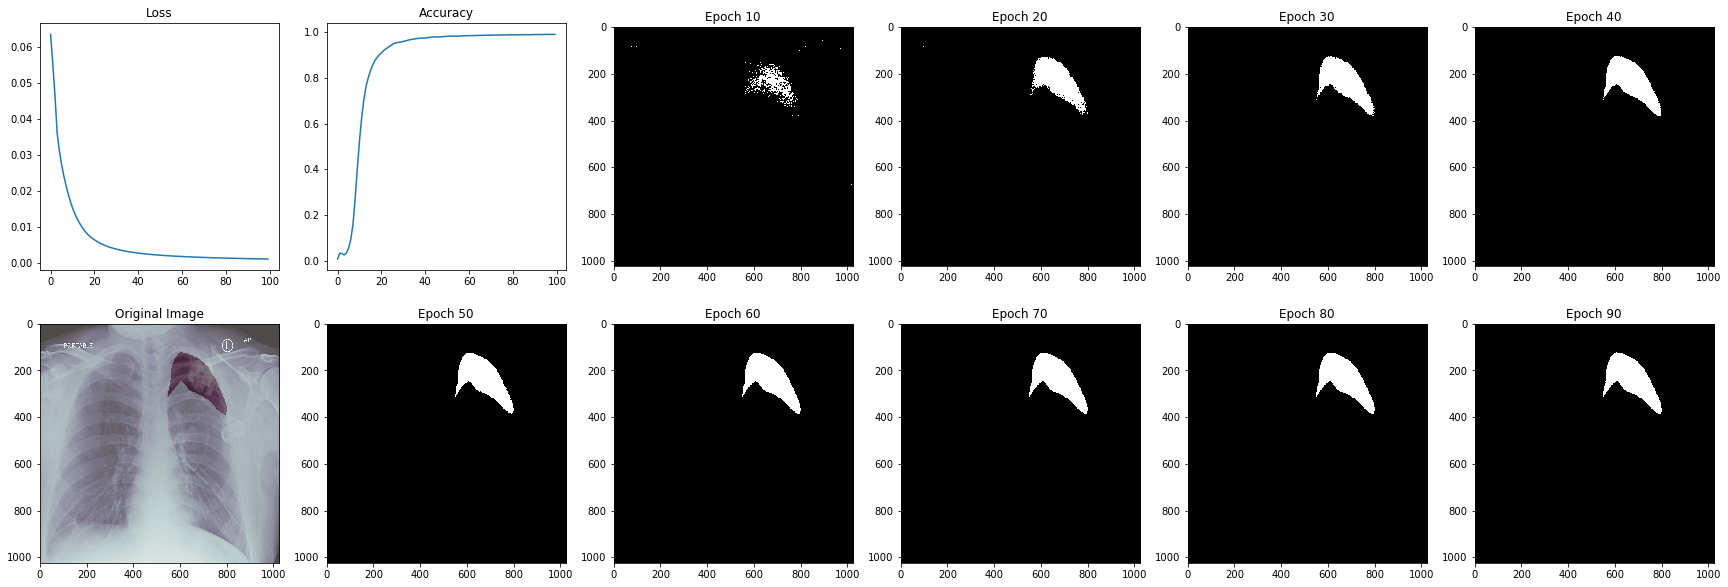

In [8]:
from torch.optim import Adam

fig, axes = plt.subplots(2, 6, figsize = (30, 10))
    
for images, masks in DataLoader(SIIMDataset('train')):
    
    if masks.sum() > 0:
        
        optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()),  lr = 1e-4)
    
        axes[1, 0].set_title('Original Image')
        axes[1, 0].imshow(images[0][0], cmap = plt.cm.bone)
        axes[1, 0].imshow(masks[0], alpha = 0.3, cmap = 'Reds')
        
        losses, accus = [], []
        
        for epoch in tqdm(range(100)):
    
            masks = masks.to(DEVICE)
        
            preds = model(images.to(DEVICE).float())
            
            loss = focal_loss(preds, masks)
            
            accu = 1 - dice_loss((preds > 0.5).float(), masks)
            
            accus.append(accu)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.cpu().item())
        
            if epoch % 10 == 0:
                
                i = epoch // 10
                
                if i > 0:
                    axes[(i // 5), (i % 5) + 1].set_title('Epoch {}'.format(epoch))
                    axes[(i // 5), (i % 5) + 1].imshow((preds[0][0] > 0.5).cpu().detach().numpy(), cmap = plt.cm.bone)

        axes[0, 0].set_title('Loss')
        axes[0, 0].plot(losses, label = 'loss')
        
        axes[0, 1].set_title('Accuracy')
        axes[0, 1].plot(accus,  label = 'accuracy')
        
        break

## Training.

In [9]:
def train(model, data_loader, optimizer, pbar = None, prev_score = 0):
    
    losses = []
    
    for images, masks in data_loader:

        outputs = model(images.to(DEVICE).float())
        loss = focal_loss(outputs, masks.to(DEVICE))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.cpu().item())

        if pbar is not None:
            pbar.set_postfix(loss = loss.cpu().item(), score = prev_score)
            pbar.update()
                
    return model, np.mean(losses)

## Validation.

In [10]:
def validate(model, data_loader, pbar = None):
        
    losses = []

    with torch.no_grad():
        for images, masks in data_loader:

            outputs = model(images.to(DEVICE).float())
            
            loss = dice_loss((outputs > 0.5).float(), masks.to(DEVICE))

            losses.append(loss.cpu().numpy())

            if pbar is not None:
                pbar.update()
    
    return 1 - np.mean(losses)

## Train Test Split.

In [11]:
from torch.utils.data import random_split

def train_test_split(dataset, p = 0.8):
    
    return random_split(dataset, [int(p * len(dataset)), len(dataset) - int(p * len(dataset))])

## Model Evalutaion.

In [ ]:
from torch.utils.data import Dataset, random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

def model_evalute(model, dataset, epoch = 10, lr = 1e-4):
    
    train_set, test_set = train_test_split(dataset)
    
    train_loader = DataLoader(train_set, batch_size = BATCH_SIZE)
    test_loader = DataLoader(test_set, batch_size = BATCH_SIZE)

    optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = lr)
    
    losses, scores = [], []
    
    with tqdm(total = epoch * (len(train_loader) + len(test_loader))) as pbar:
        for i in range(epoch):

            model, loss = train(model, train_loader, optimizer, pbar = pbar, prev_score = scores[-1] if len(scores) > 0 else 0)
            score = validate(model, test_loader, pbar)
            
            pbar.set_postfix(loss = loss, score = score)
            
            losses.append(loss)
            scores.append(score)

    ax = plt.subplot()
    
    ax.set_title('Performance')
    ax.plot(losses, label = 'loss')
    ax.plot(scores, label = 'score')
    ax.legend()
    
    return model
    
model = model_evalute(model, SIIMDataset('train'))

  1%|█▌                                                                                                                                                                                                                                                       | 811/129540 [03:02<8:14:47,  4.34it/s, loss=0.00793, score=0]

## Save Model.

In [ ]:
torch.save(model, './efficientnet-b5_unet.ckpt')

## Prediction.

In [ ]:
from lib.mask_functions import mask2rle

def predict(model, dataset, pbar = None, n = 2, m = 5):
    
    masks = {}
    
    result = pd.read_csv('./dataset/test.csv')
    
    result['EncodedPixels'] = ['-1' for i in range(len(result))]

    fig, axes = plt.subplots(n, m, figsize = (m * 5, n * 5))
    
    sample_idx = 0
    
    with torch.no_grad():
        for images, idxes in tqdm(DataLoader(dataset, batch_size = BATCH_SIZE)):
            
            outputs = (model(images.to(DEVICE).float()).cpu() > 0.5).float()
            
            for i, idx in enumerate(idxes):
                
                idx = idx.item()
                
                rle = mask2rle(outputs[i][0] * 255, outputs[i][0].shape[0], outputs[i][0].shape[1]) if outputs[i][0].sum() > 0 else '-1'
                
                result.loc[idx, 'EncodedPixels'] = rle
                
                if outputs[i][0].sum() > 0 and sample_idx < (n * m):
                    
                    axes[sample_idx // m, sample_idx % m].set_title('Test {}'.format(idx))
                    axes[sample_idx // m, sample_idx % m].imshow(images[i][0], cmap = plt.cm.bone)
                    axes[sample_idx // m, sample_idx % m].imshow(outputs[i][0], alpha = 0.3, cmap = 'Reds')
                    
                    sample_idx = sample_idx + 1
            
            if pbar is not None:
                pbar.update()
                
    return result

result = predict(model, SIIMDataset('test'))

result.to_csv('./dataset/submission.csv', index = False)

result

## References.

* [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)